In [2]:
%%pyspark
#The code below is a python script to turn the tables into a functioning python dataframe.
from pyspark.sql import SparkSession
import pandas as pd
spark = SparkSession.builder.appName("Sanitized_Refund_Lakehouse").getOrCreate()

df = spark.read.table("df_SAN_Recipient_Feedback")
feedback_df = df.toPandas()
df = spark.read.table("SAN_ApartmentNameRef")
apartment_df = df.toPandas()
df = spark.read.table("df_poverty_rates")
poverty_df = df.toPandas()
df = spark.read.table("df_SAN_Disbursements")
disbursement_df = df.toPandas()
df = spark.read.table("df_SAN_RecipientPayments")
recipient_df = df.toPandas()
print(disbursement_df)

StatementMeta(, 2ea219b2-dbff-4a8c-b57c-1d6860773652, 4, Finished, Available, Finished)

        DisbursementsId EffectiveOn   ExpiresOn  ProductsId  \
0                191151  2024-09-30  2024-10-05        1481   
1                 49387  2024-01-26  2024-01-31        2796   
2                 34802  2023-12-22  2023-12-27        3475   
3                236270  2024-12-13  2024-12-18        4559   
4                193599  2024-09-27  2024-10-02        3254   
...                 ...         ...         ...         ...   
131359            35316  2023-12-23  2023-12-28        3557   
131360            35349  2023-12-23  2023-12-28        3557   
131361            35305  2023-12-23  2023-12-28        3557   
131362            35336  2023-12-23  2023-12-28        3557   
131363            35319  2023-12-23  2023-12-28        3557   

       DisbursementStatusName Revocation_ReasonName  TotalAmount  \
0                    Complete                  None      766.155   
1                    Complete                  None     3264.944   
2                    Complete          

In [3]:
%%pyspark
merged_df = pd.merge(feedback_df, recipient_df, on='RecipientsId', how='right')
merged_df = pd.merge(merged_df, disbursement_df, on='DisbursementsId', how='left' )
merged_df = merged_df.merge(apartment_df, how='left', left_on='ProductsId', right_on='ProductId')
merged_df['Zip'] = pd.to_numeric(merged_df['Zip'], downcast='integer', errors='coerce')
merged_df = merged_df.merge(poverty_df, how='left', left_on='Zip', right_on='Zip_Code')

print(merged_df)

StatementMeta(, 2ea219b2-dbff-4a8c-b57c-1d6860773652, 5, Finished, Available, Finished)

        RecipientsId  FeedbackId CreatedOn_x  Stars  \
0             235392         NaN         NaN    NaN   
1             240792         NaN         NaN    NaN   
2             240812         NaN         NaN    NaN   
3             240801         NaN         NaN    NaN   
4             240849         NaN         NaN    NaN   
...              ...         ...         ...    ...   
192061        254195         NaN         NaN    NaN   
192062        257637         NaN         NaN    NaN   
192063        257395         NaN         NaN    NaN   
192064        254676         NaN         NaN    NaN   
192065        252433         NaN         NaN    NaN   

       _IsFeedbackMessageAvailable_Flag  DisbursementsId  IsPrimary  \
0                                   NaN           168833       True   
1                                   NaN           172694       True   
2                                   NaN           172714       True   
3                                   NaN           17270

StatementMeta(, 2ea219b2-dbff-4a8c-b57c-1d6860773652, 23, Finished, Available, Finished)

0          938.145918
1          448.630309
2          448.630309
3          448.630309
4          448.630309
             ...     
192061    1052.847046
192062     810.764388
192063     656.465887
192064    1555.327188
192065     847.683099
Name: average_disbursement, Length: 192066, dtype: float64
0         0
1         0
2         0
3         0
4         0
         ..
192061    2
192062    2
192063    2
192064    2
192065    2
Name: encoded_Disbursement_status, Length: 192066, dtype: int64


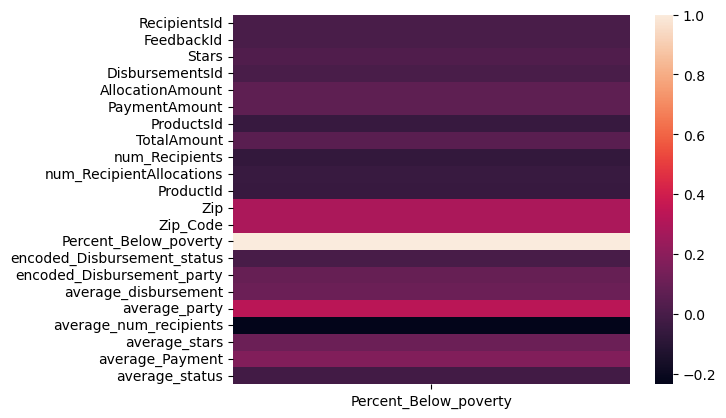

In [21]:
%%pyspark
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
merged_df['average_disbursement'] = merged_df.groupby(['Zip'])['TotalAmount'].transform('mean')
print(merged_df['average_disbursement'])
merged_df['Percent_Below_poverty'] = pd.to_numeric(merged_df['Percent_Below_poverty'], downcast='float', errors='coerce')
merged_df['encoded_Disbursement_status'] = le.fit_transform(merged_df['DisbursementStatusName'])
merged_df['encoded_Disbursement_party'] = le.fit_transform(merged_df['DisbursementPartyType'])
merged_df['average_party'] = merged_df.groupby(['Zip'])['encoded_Disbursement_party'].transform('mean')
merged_df['average_num_recipients'] = merged_df.groupby(['Zip'])['num_Recipients'].transform('mean')
merged_df['average_stars'] = merged_df.groupby(['Zip'])['Stars'].transform('mean')
merged_df['average_Payment'] = merged_df.groupby(['Zip'])['PaymentAmount'].transform('mean')
merged_df['average_status'] = merged_df.groupby(['Zip'])['encoded_Disbursement_status'].transform('mean')
print(merged_df['encoded_Disbursement_status'])
numeric_data = merged_df.select_dtypes(include=['float', 'int'])
correlation_matrix = numeric_data.corr()
correlation = correlation_matrix[['Percent_Below_poverty']]
hm = sn.heatmap(data=correlation)
plt.show()

In [4]:
-- Welcome to your new notebook
-- Type here in the cell editor to add code!
-- This SQL query is a generic query for the sake of showing access and my ability to query
SELECT * FROM SAN_Disbursements
WHERE TotalAmount BETWEEN 1000 and 6000
AND DisbursementStatusName = 'Revoked';



StatementMeta(, dcfe4615-3626-4c9b-aca8-f2e23684f416, 5, Finished, Available, Finished)

<Spark SQL result set with 118 rows and 10 fields>